# Problem definition

Given a Bank customer, can we build a classifier which can determine whether they will leave in the next 6 months or not?

URL: https://www.kaggle.com/datasets/barelydedicated/bank-customer-churn-modeling

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from numpy import percentile
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',250)
pd.set_option('display.max_rows',250)

In [ ]:

!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.3 MB/s 


In [ ]:
from category_encoders import TargetEncoder

## Read and understand data

In [ ]:
data = pd.read_csv('Churn_Modelling.csv')
print(data.shape)
data.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [ ]:
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

We will encode categorical features later, but from the first sight, we can see although some features have numerical values, their dtype in object. Firstly, we need to change them in order to get insights from them in next steps.

In [ ]:
object_types = data.select_dtypes(include=['object','category'])
object_types

,Surname,Geography,Gender
0,Hargrave,France,Female
1,Hill,Spain,Female
2,Onio,France,Female
3,Boni,France,Female
4,Mitchell,Spain,Female
...,...,...,...
9995,Obijiaku,France,Male
9996,Johnstone,France,Male
9997,Liu,France,Female
9998,Sabbatini,Germany,Male


In [ ]:
del data['RowNumber']

## Statistical Summary

In [ ]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In our dataset, tenure is spread between 1 to 8343, with an average of 4102 and Std Dev of 2603.957354 & age between 0 to 1967, with an average of 44 and Std Dev of 30.470575. It seems we should be careful while working age because of unreal numbers. We will mention it again in outlier removing step.

### Summarizing the number of unique values in each column


In [ ]:
print(data.nunique())

CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64


### Columns with  single value

Columns that have a single value are probably useless for modeling. These
columns are referred to zero-variance predictors, so we dont need to use them anymore.

In [ ]:
values = data.nunique()
single_value_cols = [values.index[i] for i,v in enumerate(values) if v == 1]
single_value_cols

[]

In [ ]:
data.drop(single_value_cols, axis=1, inplace=True)

### Checking duplicate rows

Duplicate row is a row where each value in each column for that row appears in identically the same column values in another row.  They are could be useless to the modeling process.

duplicated() function will report whether a given row is duplicated or not. All
rows are marked as either False to indicate that it is not a duplicate or True to indicate that
it is a duplicate.

In [ ]:
data.shape

(10000, 13)

In [ ]:
dups = data.duplicated(subset = data.columns.difference(['subscriber_id','target']))
print(dups.any())

data = data.drop_duplicates(subset = data.columns.difference(['subscriber_id','target']),keep = 'first')

False


In [ ]:
data.shape

(10000, 13)

## EDA

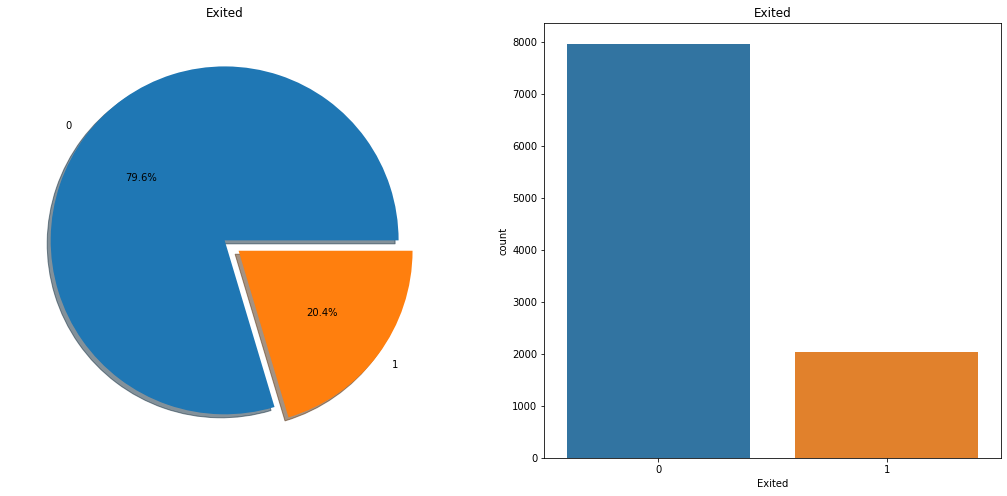

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Exited'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Exited')
ax[0].set_ylabel('')
sns.countplot('Exited',data=data,ax=ax[1])
ax[1].set_title('Exited')
plt.show()

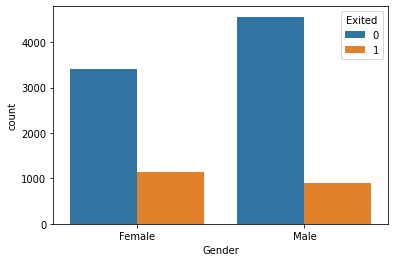

In [ ]:
sns.countplot('Gender',hue='Exited',data=data)
plt.show()

In [ ]:
# Function to create barplots that indicate percentage for each category.
def bar_perc(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        plot.annotate(percentage, (x, y), size = 12) # annotate the percentage


[Text(0.5, 1.0, 'Exited vs Gender')]

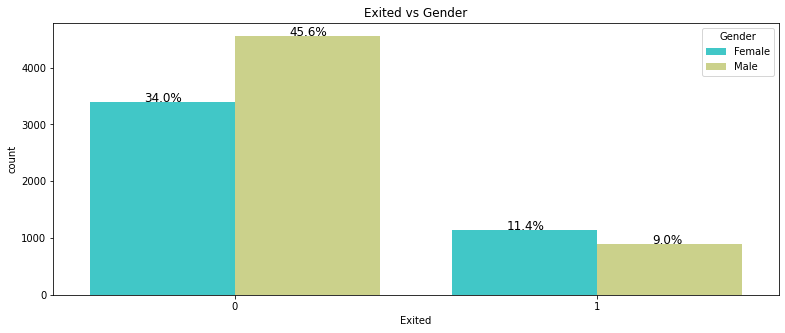

In [ ]:
plt.figure(figsize=(13,5))
ax=sns.countplot(x='Exited',hue='Gender',data=data,palette='rainbow')
bar_perc(ax,data['Exited'])
ax.set(title="Exited vs {}".format('Gender'))

### Distrubiton of all numeric features

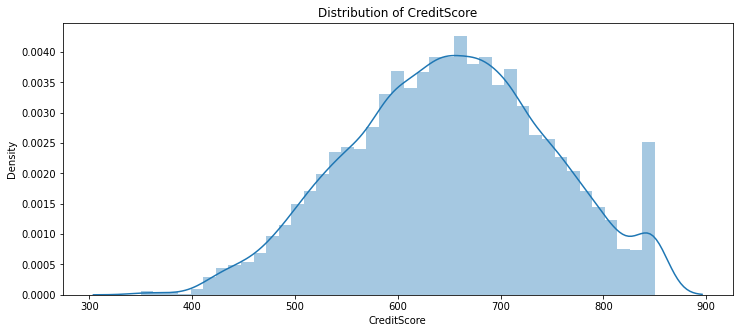

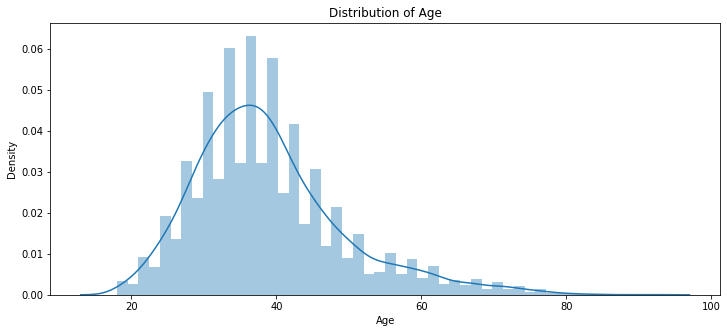

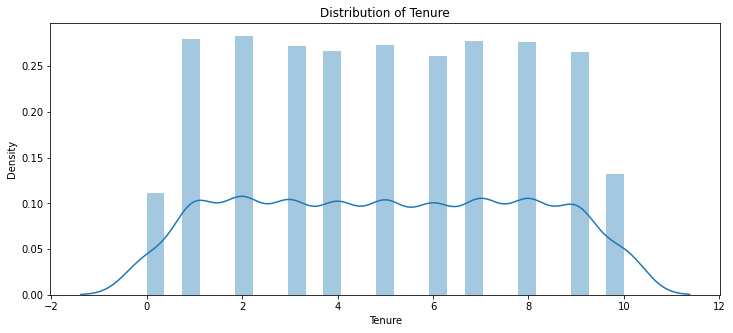

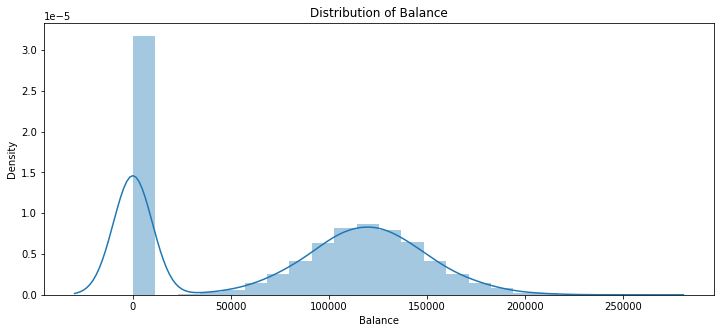

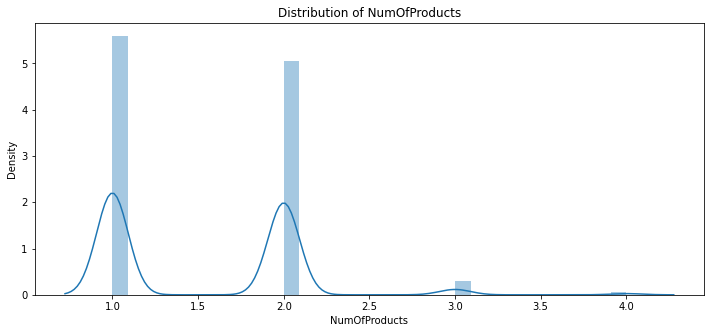

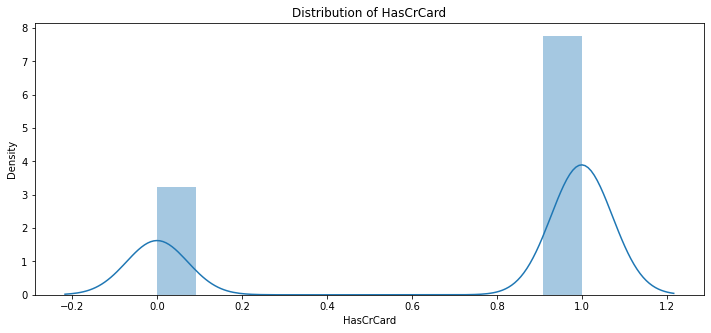

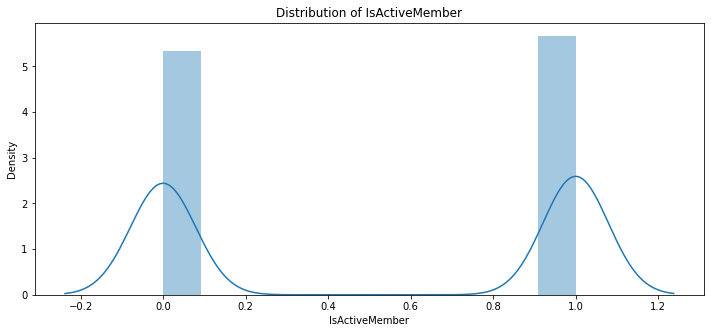

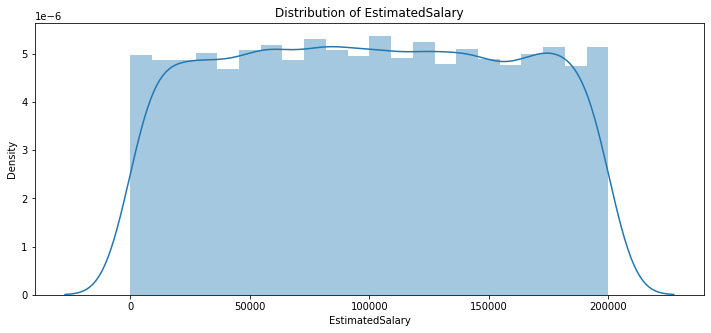

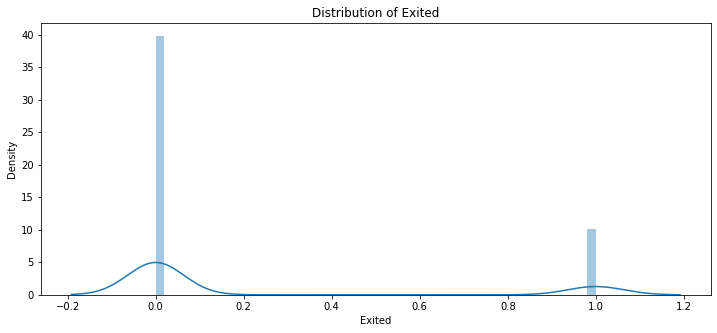

In [ ]:
numeric = data.select_dtypes(include = 'number')
for col in list(numeric)[1:]:
    plt.figure(figsize=(12,5))
    plt.title(f"Distribution of {col}")
    ax = sns.distplot(data[col])
    plt.show()

As we see, we have huge amount of outliers which have to be handled before modeling.

### Avoiding data leakage problem

Data leakage refers to a problem where information about the test dataset, is made available to the model in the training dataset. This leakage can have a marked effect on performance.

The problem with applying data preparation techniques before splitting data for model evaluation is that it can lead to data leakage and, in turn, will likely result in an incorrect estimate of a model’s performance on the problem.


In other words, data leakage means that information is revealed to the model that gives it an unrealistic advantage to make better predictions. This could happen when test data is leaked into the training set. Any time that a model is given information that it shouldn’t have access to when it is making predictions in real time in production, there is leakage.  We get data leakage by applying data preparation techniques to the entire dataset.


For this reason, I will split dataset into train and test and then will apply all pre-processing steps both of them indivudally.




In [ ]:
X = data.drop(["CustomerId", "Exited"],axis=1)
y = data.loc[:,'Exited']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

### SMOTE (Synthetic Minority Oversampling Technique)

SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

In [ ]:
print(f'X train shape is: {X_train.shape}')
print(f'X test shape is: {X_test.shape}')
print(f'y train shape is: {y_train.shape}')
print(f'y test shape is: {y_test.shape}')

X train shape is: (7000, 11)
X test shape is: (3000, 11)
y train shape is: (7000,)
y test shape is: (3000,)


## Handling with null values

Firstly, let's count number of rows with missing values

In [ ]:
for i in (X_train.columns):
    n_miss_train = X_train[i].isnull().sum()
    dtype = X_train[i].dtype
    n_miss_test = X_test[i].isnull().sum()
    perc_train = n_miss_train / X_train.shape[0] * 100
    perc_test = n_miss_test / X_test.shape[0] * 100
    print('%s, Missing in X_Train > %d (%.1f%%) > Missing in X_Test: %d (%.1f%%) > type: %s' % (i, n_miss_train, perc_train, n_miss_test, perc_test, dtype))

Surname, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: object
CreditScore, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: int64
Geography, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: object
Gender, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: object
Age, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: int64
Tenure, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: int64
Balance, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: float64
NumOfProducts, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: int64
HasCrCard, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: int64
IsActiveMember, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: int64
EstimatedSalary, Missing in X_Train > 0 (0.0%) > Missing in X_Test: 0 (0.0%) > type: float64


## Outlier removing

An outlier is an observation point that is distant from other observations. The interquartile range (IQR) is a measure of statistical dispersion and is calculated as the difference between the 75th and 25th percentiles. It is represented by the formula IQR = Q3 − Q1.


In [ ]:
def pre_quantiles(df, column, q1 = 0.25, q3 = 0.75):
    """
    This function takes dataframe, each column separetly and calculates the
    percentiles of a dataset. The IQR can then be calculated as the difference between
    the 75th and 25th percentiles
    """
    Q1 = df[column].quantile(q1)
    Q3 = df[column].quantile(q3)
    IQR = Q3-Q1
    return Q1, Q3, IQR

def remove_outliers_numerical(df, column, Q1, Q3, IQR, coeff):
    """
    This function takes dataframe, each column, their 1st and 3rd quantiles, interquartile ranges and coefficiants.
    Then calculate the cutoff for outliers as 0.5 times the IQR and subtract this cut-off
    from the 25th percentile and add it to the 75th percentile to give the actual limits on the data. As a result of
    function we get dataframe which have each column's mentioned numbers.

    """

    df_o = df[~(((df[column] < (Q1 - coeff * IQR)[column])) | ((df[column] > (Q3 + coeff * IQR)[column])))]

    return df_o

def remove_from_dataframe(df, name):
    """
    This function takes dataframe and selects numerical variables and will remove outliers from them.
    Although, it is accepted that if our dependent variable is binary, then we won't get any outliers. I will not
    exclude them due to code complexity.

    """
    del_col = df.select_dtypes(exclude = 'number').columns
    numerical_columns = df.columns.difference(del_col)
    print(f'Before removing {name} outliers: {df.shape}')

    Q_data = pd.DataFrame(pre_quantiles(df, numerical_columns, q1 = 0.005, q3 = 0.995), index=['Q1', 'Q3', 'IQR'])

    for i in numerical_columns:
        df = remove_outliers_numerical(df, i, Q_data.iloc[0]["{0}".format(i)],
                                                      Q_data.iloc[1]["{0}".format(i)], Q_data.iloc[-1], coeff = 0.5)

    print(f'After removing {name} outliers: {df.shape}\n')
    return df


In [ ]:
X_train_outlier_free = remove_from_dataframe(X_train, 'TRAIN')
X_test_outlier_free = remove_from_dataframe(X_test, 'TEST')

Before removing TRAIN outliers: (7000, 11)
After removing TRAIN outliers: (7000, 11)

Before removing TEST outliers: (3000, 11)
After removing TEST outliers: (3000, 11)



Because some rows are deleted in X, we need to take into account in our y. From now, we only will take outlier removed rows' targets.


In [ ]:

y_train = pd.DataFrame(y_train)
y_train = y_train.loc[y_train.index & X_train_outlier_free.index]


y_test = pd.DataFrame(y_test)
y_test = y_test.loc[y_test.index & X_test_outlier_free.index]

## Encoding Categorical values

In [ ]:
del X_train_outlier_free['Surname']
del X_test_outlier_free['Surname']

In [ ]:
X_train_outlier_free

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9069,619,Spain,Female,32,4,175406.13,2,1,1,172792.43
2603,643,Germany,Female,34,7,160426.07,1,0,1,188533.11
7738,561,France,Male,33,6,0.00,2,0,0,173680.39
1579,618,Germany,Male,41,8,37702.79,1,1,1,195775.48
5058,714,France,Male,37,9,148466.93,2,0,1,151280.96
...,...,...,...,...,...,...,...,...,...,...
5734,768,France,Male,54,8,69712.74,1,1,1,69381.05
5191,682,France,Female,58,1,0.00,1,1,1,706.50
5390,735,France,Female,38,1,0.00,3,0,0,92220.12
860,667,France,Male,43,8,190227.46,1,1,0,97508.04


In [ ]:

enc_dict = {'Male':0,
            'Female':1}

X_train_outlier_free['Gender'] = X_train_outlier_free['Gender'].map(enc_dict)
X_test_outlier_free['Gender'] = X_test_outlier_free['Gender'].map(enc_dict)

In [ ]:
# encode dev_man feature for train/test

encoder = TargetEncoder()
encoder.fit(X_train_outlier_free['Geography'], y_train['Exited'])
X_train_outlier_free['Geography'] = encoder.transform(X_train_outlier_free['Geography'], y_train['Exited'])
X_test_outlier_free['Geography'] = encoder.transform(X_test_outlier_free['Geography'], y_test['Exited'])

In [ ]:
X_test_outlier_free.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6252,596,0.327784,0,32,3,96709.07,2,0,0,41788.37
4684,623,0.165145,0,43,1,0.00,2,1,1,146379.30
1731,601,0.172945,1,44,4,0.00,2,1,0,58561.31
4742,506,0.327784,0,59,8,119152.10,2,1,1,170679.74
4521,560,0.172945,1,27,7,124995.98,1,1,1,114669.79


## Correlation matrix

As we done all pre-processing steps, we can plot correlation matrix in order to see feature's correlation with each other. We will drop features which have 80+ percent correlation wich each others.

In [ ]:
train_corr  = X_train_outlier_free.corr(method='pearson').abs()
train_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.00,0.01,0.01,0.01,0.01,0.01,0.02,0.00,0.02,0.00
Geography,0.01,1.00,0.02,0.05,0.00,0.40,0.01,0.00,0.02,0.01
Gender,0.01,0.02,1.00,0.04,0.02,0.01,0.02,0.00,0.02,0.01
Age,0.01,0.05,0.04,1.00,0.01,0.03,0.05,0.03,0.08,0.00
Tenure,0.01,0.00,0.02,0.01,1.00,0.01,0.01,0.02,0.02,0.02
Balance,0.01,0.40,0.01,0.03,0.01,1.00,0.30,0.02,0.02,0.01
NumOfProducts,0.02,0.01,0.02,0.05,0.01,0.30,1.00,0.01,0.03,0.01
HasCrCard,0.00,0.00,0.00,0.03,0.02,0.02,0.01,1.00,0.01,0.02
IsActiveMember,0.02,0.02,0.02,0.08,0.02,0.02,0.03,0.01,1.00,0.01
EstimatedSalary,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.01,1.00


In [ ]:
train_corr  = X_train_outlier_free.corr(method='pearson')
upper_tri = train_corr.where(np.triu(np.ones(train_corr.shape),k=1).astype(np.bool))
lower_tri = train_corr.where(np.tril(np.ones(train_corr.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
to_drop+=(column for column in lower_tri.columns if any(lower_tri[column] < -0.80))
print('Most correlated features: ', to_drop,'\n')


Most correlated features:  [] 



In [ ]:
X_train_outlier_free.shape

(7000, 10)

## Scaling

Many machine learning algorithms perform better when numerical input variables are scaled
to a standard range.  The two
most popular techniques for scaling numerical data prior to modeling are normalization and
standardization.

Normalization scales each input variable separately to the range 0-1, which is
the range for floating-point values where we have the most precision.

Standardization scales
each input variable separately by subtracting the mean (called centering) and dividing by the
standard deviation to shift the distribution to have a mean of zero and a standard deviation of
one.

__In this project, I will standardize dataset using the scikit-learn
object Normalization__

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_outlier_free)
X_test_scaled = scaler.transform(X_test_outlier_free)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

model = LogisticRegression(class_weight='balanced')
model.fit(X_train_scaled, y_train['Exited'])

ypreds=model.predict(X_test_scaled)
accuracy = (accuracy_score(ypreds ,y_test['Exited']))

# Hyperparameter optimization

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 41.4 MB/s 
     |████████████████████████████████| 81 kB 9.2 MB/s 
     |████████████████████████████████| 78 kB 5.8 MB/s 
     |████████████████████████████████| 146 kB 60.4 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 112 kB 47.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1640bdd0631a39e9e4f5463dc914f36e4187aa3fe7dbdd0f3918be7d74ebed67
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    tol = trial.suggest_float("tol", 0.0001, 0.01, log=True)
    C = trial.suggest_float("C", 1.0, 10.0, log=True)
    intercept = trial.suggest_categorical("fit_intercept", [True, False])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    ## Create Model
    classifier = LogisticRegression(penalty=penalty,
                                    tol=tol,
                                    C=C,
                                    fit_intercept=intercept,
                                    solver=solver,
                                    multi_class="auto",
                                    class_weight='balanced'
                                   )
    classifier.fit(X_train_scaled, y_train)

    return classifier.score(X_test_scaled, y_test)


random_study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.RandomSampler(),
)

random_study.optimize(objective, n_trials=25)

[I 2022-06-05 11:53:06,407] A new study created in memory with name: no-name-b6c2f026-dc19-404f-83b3-52efbc6c3299
[I 2022-06-05 11:53:06,507] Trial 0 finished with value: 0.673 and parameters: {'penalty': 'l2', 'tol': 0.0002638857257619509, 'C': 9.866658459669718, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 0 with value: 0.673.
[I 2022-06-05 11:53:06,638] Trial 1 finished with value: 0.673 and parameters: {'penalty': 'l1', 'tol': 0.0005477104372320912, 'C': 5.337802142923127, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 0 with value: 0.673.
[I 2022-06-05 11:53:06,715] Trial 2 finished with value: 0.7076666666666667 and parameters: {'penalty': 'l2', 'tol': 0.005137869849310792, 'C': 1.58361615215073, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 2 with value: 0.7076666666666667.
[I 2022-06-05 11:53:06,802] Trial 3 finished with value: 0.7073333333333334 and parameters: {'penalty': 'l1', 'tol': 0.007436797970531529, 'C': 3.863465620849988, 'fit_intercep

In [ ]:
tpe_study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

cmaes_study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.CmaEsSampler(),
)

cmaes_study.optimize(objective, n_trials=25)
tpe_study.optimize(objective, n_trials=25)
random_study.optimize(objective, n_trials=25)

[I 2022-06-05 11:54:02,007] A new study created in memory with name: no-name-04e04981-d6ac-416a-b293-73d089707a41
[I 2022-06-05 11:54:02,015] A new study created in memory with name: no-name-a0c3e18c-41cf-47be-af33-2ab46a4a5603
[I 2022-06-05 11:54:02,038] Trial 0 finished with value: 0.707 and parameters: {'penalty': 'l2', 'tol': 0.007169478799073406, 'C': 9.763290746520465, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 0 with value: 0.707.
[W 2022-06-05 11:54:02,063] The parameter 'penalty' in trial#1 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2022-06-05 11:54:02,067] The parameter 'fit_intercept' in trial#1 is sampled independently by using `R

In [ ]:
print('Baseline Logistic Regression:', accuracy)
print('CMAES with Logistic Regression: ',cmaes_study.best_value)
print('TPE with Logistic Regression: ',tpe_study.best_value)
print('Random study with Logistic Regression:', random_study.best_value)

Baseline Logistic Regression: 0.7043333333333334
CMAES with Logistic Regression:  0.708
TPE with Logistic Regression:  0.7076666666666667
Random study with Logistic Regression: 0.7076666666666667


In [ ]:
random_study.best_params


{'C': 1.58361615215073,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'saga',
 'tol': 0.005137869849310792}

In [ ]:
random_study.best_value


0.7076666666666667

In [ ]:
random_study.trials_dataframe()


,number,value,datetime_start,datetime_complete,duration,params_C,params_fit_intercept,params_penalty,params_solver,params_tol,state
0,0,0.673000,2022-06-05 11:53:06.411891,2022-06-05 11:53:06.506864,0 days 00:00:00.094973,9.866658,False,l2,saga,0.000264,COMPLETE
1,1,0.673000,2022-06-05 11:53:06.511751,2022-06-05 11:53:06.637460,0 days 00:00:00.125709,5.337802,False,l1,saga,0.000548,COMPLETE
2,2,0.707667,2022-06-05 11:53:06.646865,2022-06-05 11:53:06.715127,0 days 00:00:00.068262,1.583616,True,l2,saga,0.005138,COMPLETE
3,3,0.707333,2022-06-05 11:53:06.724135,2022-06-05 11:53:06.801979,0 days 00:00:00.077844,3.863466,True,l1,liblinear,0.007437,COMPLETE
4,4,0.673000,2022-06-05 11:53:06.821438,2022-06-05 11:53:06.877021,0 days 00:00:00.055583,9.453176,False,l1,liblinear,0.000118,COMPLETE
5,5,0.673000,2022-06-05 11:53:06.885989,2022-06-05 11:53:06.914705,0 days 00:00:00.028716,2.377641,False,l2,liblinear,0.000438,COMPLETE
6,6,0.705667,2022-06-05 11:53:06.923595,2022-06-05 11:53:07.029579,0 days 00:00:00.105984,1.636425,True,l2,saga,0.000277,COMPLETE
7,7,0.707333,2022-06-05 11:53:07.033571,2022-06-05 11:53:07.125683,0 days 00:00:00.092112,7.697638,True,l1,liblinear,0.002633,COMPLETE
8,8,0.672333,2022-06-05 11:53:07.129226,2022-06-05 11:53:07.224312,0 days 00:00:00.095086,2.455994,False,l2,saga,0.001060,COMPLETE
9,9,0.707667,2022-06-05 11:53:07.227497,2022-06-05 11:53:07.445431,0 days 00:00:00.217934,3.808551,True,l1,liblinear,0.000480,COMPLETE
